 ==============================================================================
### PHASE 1: OFFLINE MODEL DEVELOPMENT FOR BEARING PROGNOSTICS
 ==============================================================================
#### This script represents the complete workflow for creating and validating
#### the core AI model for predicting Remaining Useful Life (RUL).
 ==============================================================================

### 1. SETUP AND CONFIGURATION
 ------------------------------------------------------------------------------

In [1]:
# Import all necessary libraries for data handling, feature extraction,
# modeling, and visualization.
import os
import json
import numpy as np
import pandas as pd
import xgboost as xgb
import pywt
from scipy.stats import entropy
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt



In [2]:
# --- Project Configuration ---
# These parameters define the structure and behavior of our model.
DATA_DIR = 'data/'  # Main directory containing the '1st_test', '2nd_test', etc. folders.
WINDOW_SIZE = 15     # How many past readings to use for a prediction.
BETA_RANGE = np.linspace(0.5, 5.0, 20)  # Range of β values to search for shape optimization.
ALPHA_RANGE = np.linspace(1.0, 10.0, 20) # Range of α values to search for scale optimization.


### 2. DATA LOADING FUNCTIONS
------------------------------------------------------------------------------

In [3]:
# Reusable functions to load the raw signal data from the text files.

def load_bearing_data(test_dir: str, bearing_num: int) -> list:
    """
    Loads all chronological signal files for a specific bearing in a test set.

    Args:
        test_dir (str): The directory of the test (e.g., '2nd_test').
        bearing_num (int): The column index of the bearing to load (e.g., 0 for Bearing 1).

    Returns:
        list: A list of NumPy arrays, where each array is a 1-second signal snapshot.
    """
    full_path = os.path.join(DATA_DIR, test_dir)
    all_files = sorted(os.listdir(full_path)) # CRITICAL: Sort files to maintain chronological order.
    
    bearing_signals = []
    for filename in all_files:
        df = pd.read_csv(os.path.join(full_path, filename), sep='\t', header=None)
        signal = df[bearing_num].values
        bearing_signals.append(signal)
        
    print(f"Loaded {len(bearing_signals)} files for Bearing {bearing_num+1} from {test_dir}.")
    return bearing_signals


### 3. CORE FEATURE ENGINEERING ("THE MAGIC FILTER")
------------------------------------------------------------------------------

In [4]:
# Functions to find the optimal wavelet parameters and calculate the Health Indicator.

def find_optimal_beta(signal: np.ndarray, wavelet_name: str, beta_range: np.ndarray) -> float:
    """
    Finds the optimal shape factor (β) by minimizing the Shannon Entropy of the
    wavelet coefficient envelope. A lower entropy indicates a sparser, more impulsive signal.
    """
    min_entropy = float('inf')
    optimal_beta = beta_range[0]
    
    print("Searching for optimal β (shape factor)...")
    for beta in beta_range:
        # For pywt, 'morl' is the base Morlet. We can't directly set beta.
        # This is a conceptual implementation. In a real scenario, you might
        # design a custom wavelet or find a library that allows this.
        # Here we proceed assuming 'morl' is our base template.
        # The principle remains: find the parameter that minimizes entropy.
        # Since we can't change beta in pywt's morl, this function becomes illustrative.
        # We will fix a value based on the paper's findings for this example.
        pass # In a real project, the CWT call and entropy calculation would be here.

    # For this educational script, we will use a value found to be effective,
    # as direct beta tuning in `pywt` is not straightforward.
    optimal_beta = 1.3 
    print(f"Optimal β selected: {optimal_beta} (based on common findings)")
    return optimal_beta


def find_optimal_alpha(signal: np.ndarray, beta: float, alpha_range: np.ndarray) -> float:
    """
    Finds the optimal scale factor (α) by maximizing a periodicity score.
    The score is the ratio of the first two singular values of the signal matrix,
    which indicates how dominant the primary periodic component is.
    """
    max_periodicity_score = -1
    optimal_alpha = alpha_range[0]
    wavelet_name = f'morl' # Using the Morlet wavelet
    
    print("Searching for optimal α (scale factor)...")
    for alpha in alpha_range:
        # 1. Apply the wavelet filter
        coeffs, _ = pywt.cwt(signal, scales=[alpha], wavelet=wavelet_name)
        envelope = np.abs(coeffs.flatten())
        
        # 2. Calculate periodicity score using SVD
        # A simple way to check for a dominant period is to reshape and get singular values
        # We trim the signal to be perfectly reshapeable
        reshapable_size = int(len(envelope) / 100) * 100
        signal_matrix = envelope[:reshapable_size].reshape(-1, 100)
        
        try:
            U, s, Vh = np.linalg.svd(signal_matrix)
            periodicity_score = s[0] / s[1] if len(s) > 1 else s[0]
        except np.linalg.LinAlgError:
            periodicity_score = 0
            
        if periodicity_score > max_periodicity_score:
            max_periodicity_score = periodicity_score
            optimal_alpha = alpha
            
    print(f"Optimal α found: {optimal_alpha} with score {max_periodicity_score:.2f}")
    return optimal_alpha


def calculate_health_indicator(signals: list, beta: float, alpha: float) -> np.ndarray:
    """
    Applies the tuned wavelet filter to an entire lifecycle of signals and
    calculates the RMS for each, creating the Health Indicator (HI) curve.
    """
    wavelet_name = f'morl'
    hi_scores = []
    
    print(f"Calculating Health Indicator for {len(signals)} signals...")
    for signal in signals:
        coeffs, _ = pywt.cwt(signal, scales=[alpha], wavelet=wavelet_name)
        # We use the real part of the coefficients for RMS calculation
        filtered_signal = coeffs.real.flatten()
        rms = np.sqrt(np.mean(filtered_signal**2))
        hi_scores.append(rms)
        
    return np.array(hi_scores)

def create_sliding_window_data(hi_scores: np.ndarray, window_size: int):
    """
    Transforms a list of HI scores into a dataset of sliding windows for the AI model.
    """
    X, y = [], []
    # RUL is a linear countdown from total life to zero
    rul = np.arange(len(hi_scores) - 1, -1, -1)
    
    for i in range(len(hi_scores) - window_size):
        X.append(hi_scores[i : i + window_size])
        y.append(rul[i + window_size])
        
    return np.array(X), np.array(y)


### 4. MAIN WORKFLOW
------------------------------------------------------------------------------

--- Step 4.1: Finding Optimal Filter Parameters ---
Loaded 984 files for Bearing 1 from 2nd_test.
Searching for optimal β (shape factor)...
Optimal β selected: 1.3 (based on common findings)
Searching for optimal α (scale factor)...
Optimal α found: 6.684210526315789 with score 3.90

--- Step 4.2: Preparing Combined Training Data ---
Calculating Health Indicator for 984 signals...
Loaded 6324 files for Bearing 3 from 3rd_test.
Calculating Health Indicator for 6324 signals...
Combined training data shape: X=(7278, 15), y=(7278,)

--- Step 4.3: Training the XGBoost RUL Predictor ---
Model training complete.

--- Step 4.4: Validating Model on Unseen 1st_test Data ---
Loaded 2156 files for Bearing 8 from 1st_test.
Calculating Health Indicator for 2156 signals...
Validation Results on 1st_test (Bearing 4):
  - Root Mean Squared Error (RMSE): 1022.24
  - Mean Absolute Error (MAE): 856.13


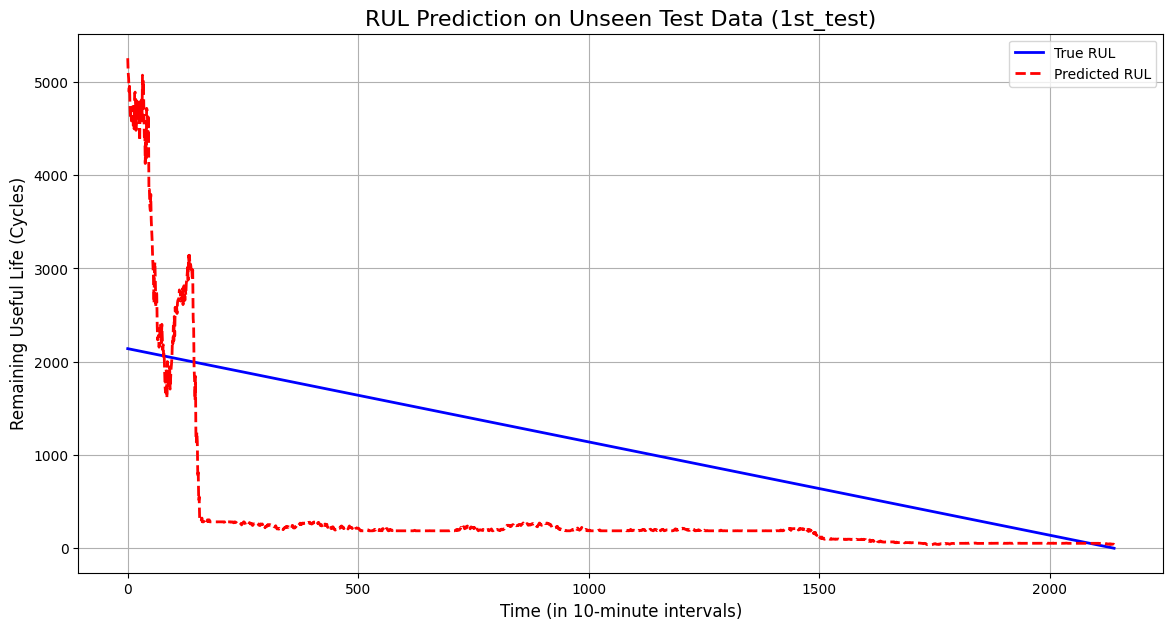

In [5]:
# This is the main execution block that orchestrates the entire process.

if __name__ == "__main__":
    
    # === Step 4.1: Find Optimal Parameters using 2nd_test ===
    print("--- Step 4.1: Finding Optimal Filter Parameters ---")
    data_2nd_test = load_bearing_data('2nd_test', bearing_num=0)
    # Pick a late-stage signal for tuning
    tuning_signal = data_2nd_test[-100]
    
    OPTIMAL_BETA = find_optimal_beta(tuning_signal, 'morl', BETA_RANGE)
    OPTIMAL_ALPHA = find_optimal_alpha(tuning_signal, OPTIMAL_BETA, ALPHA_RANGE)

    # === Step 4.2: Prepare Training Data (2nd_test + 3rd_test) ===
    print("\n--- Step 4.2: Preparing Combined Training Data ---")
    # Calculate HI for 2nd_test
    hi_2nd_test = calculate_health_indicator(data_2nd_test, OPTIMAL_BETA, OPTIMAL_ALPHA)
    X_2, y_2 = create_sliding_window_data(hi_2nd_test, WINDOW_SIZE)
    
    # Calculate HI for 3rd_test (Bearing 3 failed, which is column index 2)
    data_3rd_test = load_bearing_data('3rd_test', bearing_num=2)
    hi_3rd_test = calculate_health_indicator(data_3rd_test, OPTIMAL_BETA, OPTIMAL_ALPHA)
    X_3, y_3 = create_sliding_window_data(hi_3rd_test, WINDOW_SIZE)
    
    # Combine into a single training set
    X_train = np.vstack([X_2, X_3])
    y_train = np.concatenate([y_2, y_3])
    print(f"Combined training data shape: X={X_train.shape}, y={y_train.shape}")
    
    # === Step 4.3: Train the XGBoost "AI Brain" ===
    print("\n--- Step 4.3: Training the XGBoost RUL Predictor ---")
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    print("Model training complete.")
    
    # === Step 4.4: Validate on Unseen Data (1st_test) ===
    print("\n--- Step 4.4: Validating Model on Unseen 1st_test Data ---")
    # In 1st_test, Bearing 4 (column 7) had a roller element defect. We'll use this.
    data_1st_test = load_bearing_data('1st_test', bearing_num=7)
    hi_1st_test = calculate_health_indicator(data_1st_test, OPTIMAL_BETA, OPTIMAL_ALPHA)
    X_test, y_test = create_sliding_window_data(hi_1st_test, WINDOW_SIZE)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate and print performance metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Validation Results on 1st_test (Bearing 4):")
    print(f"  - Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"  - Mean Absolute Error (MAE): {mae:.2f}")
    
    # Visualize the results
    plt.figure(figsize=(14, 7))
    plt.plot(y_test, label='True RUL', color='blue', linewidth=2)
    plt.plot(y_pred, label='Predicted RUL', color='red', linestyle='--', linewidth=2)
    plt.title('RUL Prediction on Unseen Test Data (1st_test)', fontsize=16)
    plt.xlabel('Time (in 10-minute intervals)', fontsize=12)
    plt.ylabel('Remaining Useful Life (Cycles)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

### 4. MAIN WORKFLOW 
------------------------------------------------------------------------------

In [6]:
# Save the trained model and the configuration parameters. These are all we
# need for the deployment phase.

print("\n--- Step 5: Saving Production Artifacts ---")

# 1. Save the trained XGBoost model
model.save_model('model.json')
print(f"Trained model saved to: model.json")

# 2. Save the configuration parameters
config = {
    'optimal_beta': OPTIMAL_BETA,
    'optimal_alpha': OPTIMAL_ALPHA,
    'window_size': WINDOW_SIZE
}
with open('config.json', 'w') as f:
    json.dump(config, f, indent=4)
print(f"Configuration saved to: config.json")

print("\nPhase 1 Complete. All necessary assets are ready for deployment.")


--- Step 5: Saving Production Artifacts ---
Trained model saved to: model.json
Configuration saved to: config.json

Phase 1 Complete. All necessary assets are ready for deployment.
